# Post-processing simulation using Kuibit 

**General structure**:

- Import libraries
- Load simulation directory
    - Print all files
    - Extract available iterations: `sim.gf.xyz['kxx'].available_iterations`
    - Define `avail_iter_max = avail_iter[-1]`
    - Define `diter = avail_iter[1]-avail_iter[0]`
- Define Hamiltonian and Momentum average timeseries 

- Define GridFunctions for all available variables: 
    - Matter density `rho`
    - Extrinsic curvature `kxx` 
    - Trace of K `trK`
    - Spatial metric `gxx`
    - Determinant of g `detg`
    - Ricci tensor `Ricci11`
    - Ricci scalar `Ricci`

- Plot Hamiltonian and Momentum timeseries
    - Maybe discard some of the final iterations 

- Define corresponding background quantities (FLRW flat dust model or EdS)
    - Definitions from **ICCalc.F90**: $s=aa/a0$, $H$, $\Omega_m$
        - $\bar{K}=-3K$
        - $\bar{\gamma}=a^6$
        - $\bar{\rho}=3H^2 \Omega_m/\kappa$

    - Definitions from Robyn for $\Lambda=0$ (Validate!)
        - I think the formulas for FLRW are still valid here, and we just need to change: 
            - $s=\left(\frac{\tau}{\tau_0}\right)^{2/3}$
            - $H=\frac{2}{3\tau}$
            - $\Omega_m=1.0$    

- Define a coarse scale factor `aa_co` from timeseries, avail_iter_max and diter.
 
- Calculate redshift $z$ from coarse scale factor $a(\tau)$  

- Calculate density contrast, extrinsic curvature contrast, metric contrast     
    - Plot curves at the underdensity, underdensity and center of the box 
    - Plot outer and inner surfaces for the density contrast 
    - Try and do a 3D animation with isosurfaces of the density contrast at $z_{IN}$ to show:
        1. Spherical symmetry near to OD
        2. Filamentary-like structures
        3. Periodic Boundary conditions
        4. compensated inhomogeneity (just one lambda, linear average vanishes)

In [1]:
# Use et2 for compatibility
from kuibit.simdir import SimDir
import kuibit.visualize_matplotlib as viz
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import itertools

from localutils import delta_ini, redshift

# set plot theme 
sns.set_theme(context='notebook', style='darkgrid', palette='colorblind')

In [ ]:
# In case the scrip being used is a cached one

import importlib
import localutils

# Force the notebook to reload the module
importlib.reload(localutils)

<module 'localutils' from '/home/jorge/Desktop/KuibitPostprocessing/localutils.py'>

In [2]:
pathtosimdir = '/home/jorge/Downloads/output-0000/testPert32_J'

sim = SimDir(pathtosimdir) 
print(sim)

Indexed 34 files and 1 subdirectories
Folder /home/jorge/Downloads/output-0000/testPert32_J
/home/jorge/Downloads/output-0000/testPert32_J
Available scalar timeseries:
[]

Available minimum timeseries:
[]

Available maximum timeseries:
[]

Available norm1 timeseries:
[]

Available norm2 timeseries:
[]

Available average timeseries:
['kxx', 'kxy', 'kxz', 'kyy', 'kyz', 'kzz', 'gxx', 'gxy', 'gxz', 'gyy', 'gyz', 'gzz', 'alp', 'H', 'rho', 'betax', 'betay', 'betaz', 'M1', 'M2', 'M3']
Variables available: dict_keys([])

Available grid data of dimension 1D (x): 
[]


Available grid data of dimension 1D (y): 
[]


Available grid data of dimension 1D (z): 
[]


Available grid data of dimension 2D (xy): 
[]


Available grid data of dimension 2D (xz): 
[]


Available grid data of dimension 2D (yz): 
[]


Available grid data of dimension 3D (xyz): 
['kxx', 'kxy', 'kxz', 'kyy', 'kyz', 'kzz', 'Ricci11', 'Ricci12', 'Ricci13', 'Ricci22', 'Ricci23', 'Ricci33', 'Ricci', 'trK', 'detg', 'NaNmask', 'rho', '

In [4]:
# Available iterations, cctk_time and box size
box = int(pathtosimdir[-4:-2])
p = box//4        # OD index          
t = sim.ts.average['H'].t
dt = t[1] - t[0]
avail_iter = sim.gf.xyz['gxx'].available_iterations 
avail_iter_max = avail_iter[-1]
diter = avail_iter[1]-avail_iter[0]

# Initial matter density contrast at the OD
del_ini = delta_ini(sim, p)      

# Info
print(f'---  Simulation {pathtosimdir[-1]} info  ---\n')
print(f'Box size   = {box}')
print(f'Avail iter = {sim.gf.xyz['gxx'].available_iterations[:3]} ... {sim.gf.xyz['kxx'].available_iterations[-3:]}')
print(f'cctk_time  = {t[:3]} ... {t[-3:]}')
print(r'$\delta_{OD,IN}$ = ', del_ini)
print('\n---    ---   ---   ---')

---  Simulation J info  ---

Box size   = 32
Avail iter = [0, 100, 200] ... [36100, 36200, 36300]
cctk_time  = [1.  2.2 3.4] ... [434.2 435.4 436.6]
$\delta_{OD,IN}$ =  0.029999673196473564

---    ---   ---   ---


Define timeseries and grid functions

In [5]:
# Hamiltonian and momentum timeseries

M1 = sim.timeseries.average['M1']
M2 = sim.timeseries.average['M2']
M3 = sim.timeseries.average['M3']
H  = sim.timeseries.average['H']

# Grid functions

## Extrinsic curvature and spatial metric
kxx, gxx = sim.gf.xyz['kxx'], sim.gf.xyz['gxx']     # sim.gf.dim['var'][iteration]
kxy, gxy = sim.gf.xyz['kxy'], sim.gf.xyz['gxy']
kxz, gxz = sim.gf.xyz['kxz'], sim.gf.xyz['gxz']
kyy, gyy = sim.gf.xyz['kyy'], sim.gf.xyz['gyy']
kyz, gyz = sim.gf.xyz['kyz'], sim.gf.xyz['gyz']
kzz, gzz = sim.gf.xyz['kzz'], sim.gf.xyz['gzz']

## Ricci tensor and Ricci scalar
Rxx, Ryy, Rzz = sim.gf.xyz['Ricci11'], sim.gf.xyz['Ricci22'], sim.gf.xyz['Ricci33']
Rxy, Rxz = sim.gf.xyz['Ricci12'], sim.gf.xyz['Ricci13']
Ryz = sim.gf.xyz['Ricci23']
R = sim.gf.xyz['Ricci']

## Matter density, trace of K, determinant of g
rho = sim.gf.xyz['rho']
trk = sim.gf.xyz['trK']
detg= sim.gf.xyz['detg'] 

In [6]:
# Sanity Check: Ricci scalar at OD and UD, at z_IN

print(max(R[0][0][0][:,:,:].flatten()), min(R[0][0][0][:,:,:].flatten()))
print(R[0][0][0][p,p,p], R[0][0][0][-p,-p,-p])

0.1314248331343118 -0.12523647791358
0.1314248331343118 -0.12523647791358


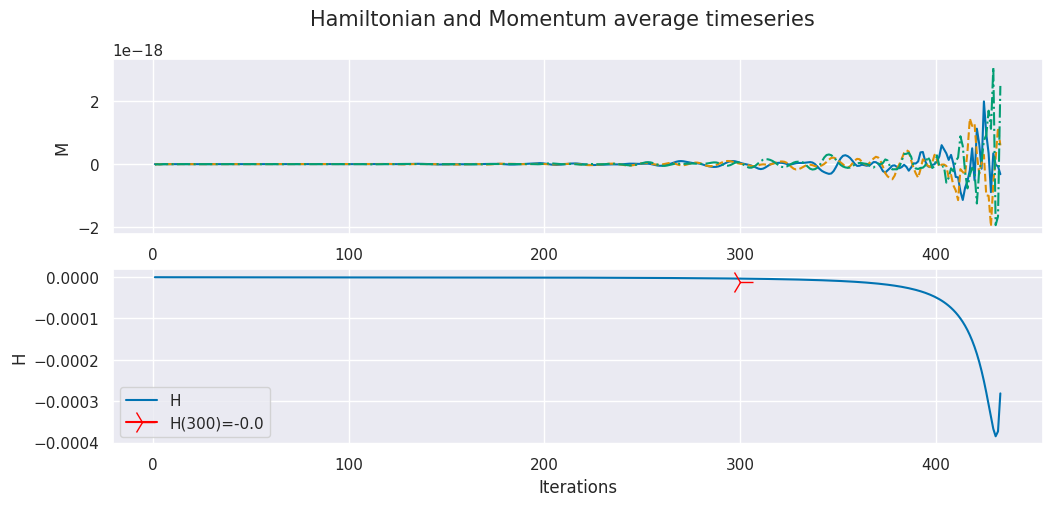

In [8]:
# Constraints plots

short = 3         # number of iterations to leave out   
plt.figure(figsize=(12,5))
plt.suptitle("Hamiltonian and Momentum average timeseries", fontsize=15)
plt.subplot(2,1,1)
plt.plot(M1.t[:-short], M1.y[:-short], label='M1')
plt.plot(M3.t[:-short], M3.y[:-short], label='M2', linestyle='--')
plt.plot(M3.t[:-short], M2.y[:-short], label='M3', linestyle='-.')
plt.ylabel('M')
#plt.legend()

n=300             # iteration to mark  
H_n = round(H.y[n],4)
plt.subplot(2,1,2)
plt.plot(H.t[:-short], H.y[:-short], label='H')
plt.plot(n, H.y[n], label=f'H({n})={H_n}', color="red", marker="4", markersize=18)
plt.xlabel('Iterations')
plt.ylabel('H')
plt.legend()

Background quantities 

$h=H_0/100$
$[H]=km/s/Mpc$      

Probar escalar el H0 escalado por h o h^-1

In [9]:
# Constants, parameters, scale factor 

# Constants
G=1.
kappa = 8. * np.pi * G
Omega_matter0 = 0.3147                
Omega_lambda0 = 1. - Omega_matter0
ICPertFLRW_h = 0.6737                   # Dimenstionless hubble parameter
z_comoving_ref = 0.
a0 = 1. + z_comoving_ref                # Comoving reference redshift: a_0= 1+z_comoving_ref
H0 = ICPertFLRW_h * 1. / 2997.9         # 1/Mpc ; 2997.9 [Mpc]
t0_EdS= 2. / ( 3. * H0 )                # Used for both models
    
# Actual calculations (ICCalc.F90 and param.ccl)
def a_factor(t):
    scale_factor = a0 * (Omega_matter0 / Omega_lambda0 )**(1./3.)*\
        (np.sinh( np.sqrt(Omega_lambda0) * t / t0_EdS ) ** (2./3.))
    return scale_factor  

aa = a_factor(t)
Hprop = H0 * np.sqrt(Omega_matter0 * ( aa / a0 )**(-3.) + Omega_lambda0)
Omega_matter = Omega_matter0 / ( Omega_matter0 + Omega_lambda0 * ( aa / a0 )**3.) 

# Background density and spatial metric
rhoflrw = 3. * Hprop**2. * Omega_matter / kappa
gammaflrw = aa**6.


In [10]:
aa[0], a_factor(1), 1/a_factor(1)-1

(0.003294524141074402, 0.003294524141074402, 302.53397248862854)

In [ ]:
# Check synchronization between timeseries and grid functions

aa_co = aa
sync = len(avail_iter)==t.shape[0]
print(t.shape, len(avail_iter), avail_iter_max)        
print(f'Synchronized = {sync}')

if not sync:
    rhoflrw_co = rhoflrw[:avail_iter_max+1:diter]
    H_coarse = Hprop[:avail_iter_max+1:diter]
else:
    rhoflrw_co = rhoflrw
    H_coarse = Hprop        

# Make a conditional to check wether the the timeseries are synchronized wit the gf or not, and
# based on that define the coarse arrays for H and rhoflrw    


(364,) 364 36300
Synchronized = True


In [12]:
# Matter density contrast, volume contrast, expansion contrast
# Ricci scalar and trace of K
# At the OD, UD and CT

## Matter density contrast
delta_rho_OD = [rho[i][0][0][  p,  p,  p] for i in avail_iter]/rhoflrw_co -1.
delta_rho_UD = [rho[i][0][0][ -p, -p, -p] for i in avail_iter]/rhoflrw_co -1.
delta_rho_CT = [rho[i][0][0][2*p,2*p,2*p] for i in avail_iter]/rhoflrw_co -1.

## Volume contrast 
delta_gamma_OD = np.array([detg[i][0][0][  p,  p,  p] for i in avail_iter])/aa_co**6 -1.
delta_gamma_UD = np.array([detg[i][0][0][ -p, -p, -p] for i in avail_iter])/aa_co**6 -1.
delta_gamma_CT = np.array([detg[i][0][0][2*p,2*p,2*p] for i in avail_iter])/aa_co**6 -1.

## Ricci
R_OD = np.array([R[i][0][0][  p,  p,  p] for i in avail_iter])
R_UD = np.array([R[i][0][0][ -p, -p, -p] for i in avail_iter])
R_CT = np.array([R[i][0][0][2*p,2*p,2*p] for i in avail_iter])

### Determinant of gamma
gamma_OD = np.array([detg[i][0][0][  p,  p,  p] for i in avail_iter])
gamma_UD = np.array([detg[i][0][0][ -p, -p, -p] for i in avail_iter])
gamma_CT = np.array([detg[i][0][0][2*p,2*p,2*p] for i in avail_iter])


## Expansion contrast 
delta_trk_OD = np.array([trk[i][0][0][  p,  p,  p] for i in avail_iter])/(-3.0*H_coarse) - 1.
delta_trk_UD = np.array([trk[i][0][0][ -p, -p, -p] for i in avail_iter])/(-3.0*H_coarse) - 1.
delta_trk_CT = np.array([trk[i][0][0][2*p,2*p,2*p] for i in avail_iter])/(-3.0*H_coarse) - 1.


Matter density contrast

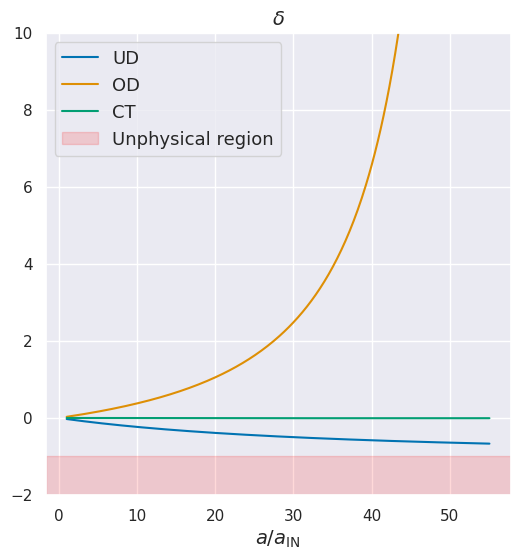

In [20]:
plt.figure(figsize=(6, 6))

short = 340
x = aa_co/aa_co[0] 
plt.plot(x[:short], delta_rho_UD[:short], label='UD')
plt.plot(x[:short], delta_rho_OD[:short], label='OD')
plt.plot(x[:short], delta_rho_CT[:short], label='CT')
plt.ylim(ymin=-2,ymax=10)
plt.xlabel(r'$a/a_{\text{IN}}$', fontsize=14)
plt.title(r'$\delta$', fontsize=14)
#plt.title(r'$\delta_{OD} \text{ and } \delta_{UD} $', fontsize=14)

plt.axhspan(ymin=-2, ymax=-1, color='red', alpha=0.15, label='Unphysical region')
plt.legend(fontsize=13);
#plt.annotate(
#    'A_pert=7.5e-4\nlambda_pert=640',  # Annotation text
#    xy=(5, 3.5),     # Point being annotated (arrow target)
#    xytext=(8, 3.5), # Position of the text
#    #arrowprops=dict(facecolor='black', shrink=0.05), # Arrow properties
#    ha='center'    # Horizontal alignment of the text
#)

Volume contrast

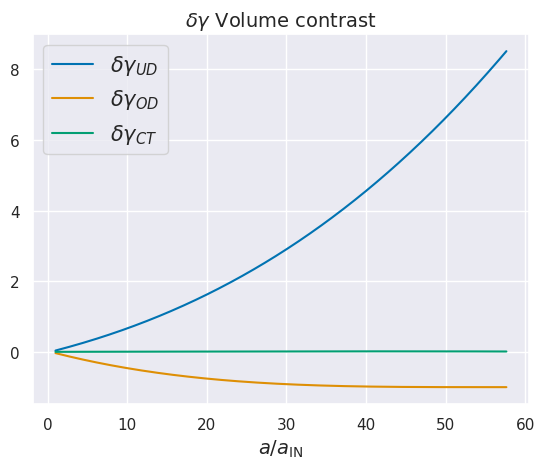

In [14]:
#plt.figure(figsize=(6, 6))

short = 460 #avail_iter_max//diter

plt.title(r'$\delta\gamma$ Volume contrast', fontsize=14)
plt.plot(aa_co[:short]/aa[0], delta_gamma_UD[:short], label=r'$\delta\gamma_{UD}$')
plt.plot(aa_co[:short]/aa[0], delta_gamma_OD[:short], label=r'$\delta\gamma_{OD}$')
plt.plot(aa_co[:short]/aa[0], delta_gamma_CT[:short], label=r'$\delta\gamma_{CT}$')
plt.legend(fontsize=15);
plt.xlabel(r'$a/a_{\text{IN}}$', fontsize=14);

#plt.hlines(y=-1, xmin=0, xmax=20, linestyle='--', colors='k', lw=.8)

Expansion contrast

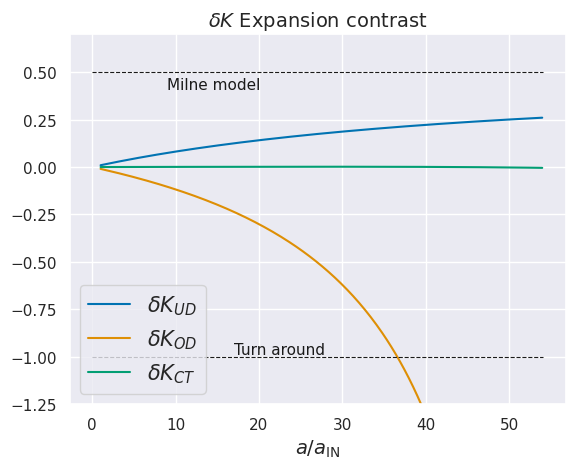

In [15]:
#plt.figure(figsize=(6, 6))

short = 330

plt.title(r'$\delta K$ Expansion contrast', fontsize=14)
plt.plot(aa_co[:short]/aa[0], delta_trk_UD[:short], label=r'$\delta K_{UD}$')
plt.plot(aa_co[:short]/aa[0], delta_trk_OD[:short], label=r'$\delta K_{OD}$')
plt.plot(aa_co[:short]/aa[0], delta_trk_CT[:short], label=r'$\delta K_{CT}$')
plt.hlines(y=-1, xmin=0, xmax=aa_co[short]/aa[0], linestyle='--', colors='k', lw=.8)
plt.text(17, -0.989, 'Turn around', fontsize=11, color='k')
plt.hlines(y=.5, xmin=0, xmax=aa_co[short]/aa[0], linestyle='--', colors='k', lw=.8)
plt.text(9, 0.41, 'Milne model', fontsize=11, color='k')
plt.ylim(ymin=-1.25, ymax=0.7)
plt.legend(fontsize=15)
plt.xlabel(r'$a/a_{\text{IN}}$', fontsize=14);


$a^{2(3)}  R[\lambda_{pert}^2]$

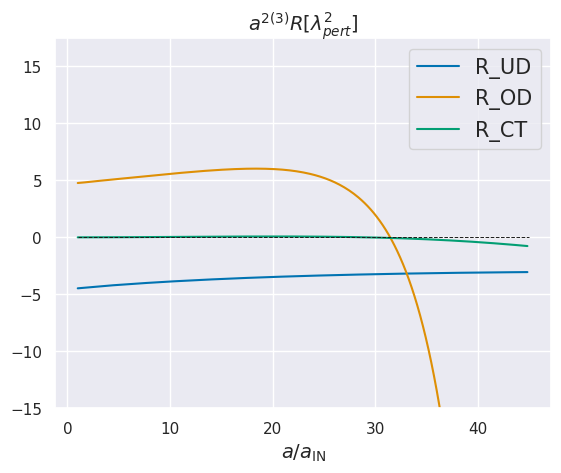

In [ ]:
#plt.figure(figsize=(6, 6))

short = 250
l_pert = 1821     # lambda_pert [Mpc] (?)

plt.title(r'$a^{2(3)}  R[\lambda_{pert}^{-2}]$', fontsize=14)
plt.plot(aa[:short]/aa[0],l_pert**2 * (aa**2 *R_UD)[:short], label='R_UD')
plt.plot(aa[:short]/aa[0],l_pert**2 * (aa**2 *R_OD)[:short], label='R_OD')
plt.plot(aa[:short]/aa[0],l_pert**2 * (aa**2 *R_CT)[:short], label='R_CT')
plt.hlines(y=0, xmin=1, xmax=aa[short]/aa[0], linestyle='--', linewidth=.7, color='k')
plt.legend(fontsize=15)
plt.xlabel(r'$a/a_{\text{IN}}$', fontsize=14)
plt.ylim(ymin=-15);

Ricci with $\gamma^{1/3}$

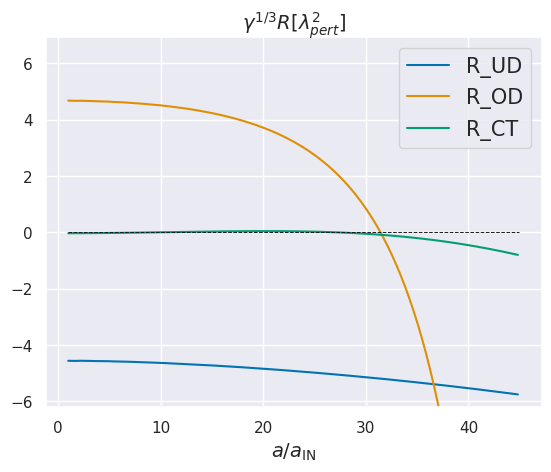

In [17]:
#plt.figure(figsize=(6, 6))

short = 250
exp = 1/3

plt.title(r'$\gamma^{1/3}  R[\lambda_{pert}^2]$', fontsize=14)
plt.plot(aa[:short]/aa[0],l_pert**2 * (gamma_UD**exp *R_UD)[:short], label='R_UD')
plt.plot(aa[:short]/aa[0],l_pert**2 * (gamma_OD**exp *R_OD)[:short], label='R_OD')
plt.plot(aa[:short]/aa[0],l_pert**2 * (gamma_CT**exp *R_CT)[:short], label='R_CT')
plt.hlines(y=0, xmin=1, xmax=aa[short]/aa[0], linestyle='--', linewidth=.7, color='k')
plt.legend(fontsize=15)
plt.xlabel(r'$a/a_{\text{IN}}$', fontsize=14)
plt.ylim(ymin=-6.2);

- Notar que en la simulación de Robyn, estas curvas: 
    1. Son más estables y la OD colapsa alrededor de $a/a_{IN}\sim 50$ 
    2. En el centro de la caja, la curva comienza a desviarse hacia arriba
    3. Presentan una pequeña anomalía en el comienzo $a/a_{IN}\sim 1$

- En mi simulación parace ser que estas cantidades no se están conservando ni siquiera en el comienzo    

Normalized Ricci with $\gamma^{1/3}$ 

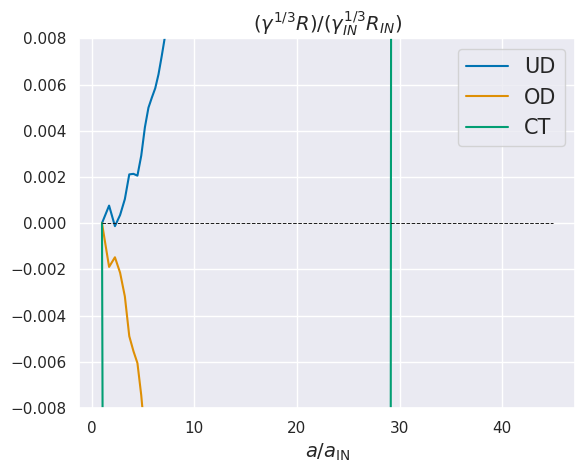

In [21]:
#plt.figure(figsize=(6, 6))

short = 250
exp = 1/3

y_UD = (gamma_UD**exp *R_UD)/(gamma_UD[0]**exp *R_UD[0]) -1 
y_OD = (gamma_OD**exp *R_OD)/(gamma_OD[0]**exp *R_OD[0]) -1
y_CT = (gamma_CT**exp *R_CT)/(gamma_CT[0]**exp *R_CT[0]) -1

plt.title(r'$(\gamma^{1/3}R)/(\gamma_{IN}^{1/3}R_{IN})$', fontsize=14)
plt.plot(aa[:short]/aa[0], y_UD[:short], label='UD')
plt.plot(aa[:short]/aa[0], y_OD[:short], label='OD')
plt.plot(aa[:short]/aa[0], y_CT[:short], label='CT')
plt.hlines(y=0, xmin=1, xmax=aa[short]/aa[0], linestyle='--', linewidth=.7, color='k')
plt.legend(fontsize=15)
plt.xlabel(r'$a/a_{\text{IN}}$', fontsize=14)
plt.ylim(ymin=-8e-3, ymax=8e-3);

# To make the 2 plots with shared axis see test.ipynb

Text(0.5, 0, '$a/a_{\\text{IN}}$')

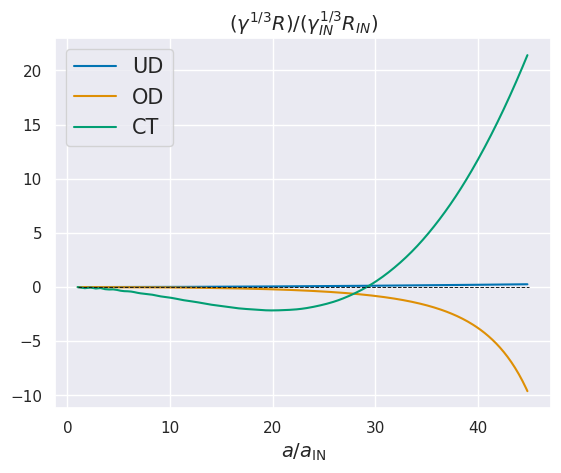

In [19]:
plt.title(r'$(\gamma^{1/3}R)/(\gamma_{IN}^{1/3}R_{IN})$', fontsize=14)
plt.plot(aa[:short]/aa[0], y_UD[:short], label='UD')
plt.plot(aa[:short]/aa[0], y_OD[:short], label='OD')
plt.plot(aa[:short]/aa[0], y_CT[:short], label='CT')
plt.hlines(y=0, xmin=1, xmax=aa[short]/aa[0], linestyle='--', linewidth=.7, color='k')
plt.legend(fontsize=15)
plt.xlabel(r'$a/a_{\text{IN}}$', fontsize=14)
#plt.ylim(ymin=-8e-3, ymax=8e-3);

- Quizás necesitamos **más resolución** (en la frecuencia de output de la simulación) para este plot, o bien la simulación es mala
- Esta última opción sería coherente con las gráficas obtenidas anteriormente para $a^2 R$ y $\gamma^{1/3}R$
- Esta última gráfica es muy interesante
    - Notar que en la de Robyn esta depresión no es tan pronunciada y además pasado $a/a_{IN}\sim 20$ los valores son estrictamente positivos